In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.cluster import Birch
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
import random
from sklearn.decomposition import PCA

In [3]:
#importing dataset
from keras.datasets import cifar10

In [100]:
(X_train,Y_train),(X_test,Y_test) = cifar10.load_data()

In [65]:
#Standardise the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train/=255 
X_test/=255

Image size : 32 x 32 x 3

Training set size : 50000

Test set size     : 10000

We now perform k-fold cross validation and pick the best model amongst all of them. We divide the data into 4 and pick one of them as the cross validation set and the remaining as the train set. This helps us to check for overfitting.

# Model Training 

In [67]:
kfold = StratifiedKFold(n_splits=4, shuffle=True)
cvscores = []

In [68]:
count=1

big_history={}

#Model

for train,test in kfold.split(X_train,Y_train):
    
    #encoder
    
    input_img = tf.keras.layers.Input(shape=(32, 32, 3))
        
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_img)
    batch1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch1)
    batch2 = tf.keras.layers.BatchNormalization()(conv1)

    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(batch2)
    drop1 = tf.keras.layers.Dropout(0.7)(pool1)


    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop1)
    batch3 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch3)
    batch4 = tf.keras.layers.BatchNormalization()(conv2)


    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(batch4)
    drop2 = tf.keras.layers.Dropout(0.7)(pool2)


    conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop2)
    batch5 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch5)
    batch6 = tf.keras.layers.BatchNormalization()(conv3)


    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(batch6)
    drop3 = tf.keras.layers.Dropout(0.7)(pool3)

    conv_bottom = tf.keras.layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop3)
    conv_bottom = tf.keras.layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_bottom)


    ###############################################################################################################################################################################

    #decoder 
    
    up1 = tf.keras.layers.Conv2DTranspose(filters = 128,kernel_size = (3,3),strides = 2,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv_bottom)
    merge1 = tf.keras.layers.concatenate([batch6,up1], axis = 3)
    conv5 = tf.keras.layers.Conv2D(filters = 128,kernel_size =(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
    batch9 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(filters = 128,kernel_size =(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch9)
    batch10 = tf.keras.layers.BatchNormalization()(conv5)
    drop4  = tf.keras.layers.Dropout(0.7)(batch10)

    up2 = tf.keras.layers.Conv2DTranspose(filters = 64,kernel_size = (3,3),strides = 2,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(drop4)
    merge2 = tf.keras.layers.concatenate([batch4,up2], axis = 3)
    conv6 = tf.keras.layers.Conv2D(filters = 64,kernel_size =(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
    batch11 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = tf.keras.layers.Conv2D(filters = 64,kernel_size =(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch11)
    batch12 = tf.keras.layers.BatchNormalization()(conv6)
    drop5 = tf.keras.layers.Dropout(0.7)(batch12)

    up3 = tf.keras.layers.Conv2DTranspose(filters = 32,kernel_size = (3,3),strides = 2,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(drop5)
    merge3 = tf.keras.layers.concatenate([batch2,up3], axis = 3)
    conv7 = tf.keras.layers.Conv2D(filters = 32,kernel_size =(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    batch13 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = tf.keras.layers.Conv2D(filters = 32,kernel_size =(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(batch13)
    batch14 = tf.keras.layers.BatchNormalization()(conv7)
    drop6 = tf.keras.layers.Dropout(0.7)(batch14)
    output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=1, activation='sigmoid', padding='same')(drop6)

    autoencoder = tf.keras.models.Model(input_img,output)  
    autoencoder.compile(loss='mean_squared_error', optimizer='Adam')
    history = autoencoder.fit(X_train[train],X_train[train],batch_size=64,shuffle=True,epochs=20)
    big_history[count]=history.history#storing the training losses to be used in plotting later on
    scores = autoencoder.evaluate(X_train[test],X_train[test],verbose=0)
    s="model_"+str(count)
    count+=1
    autoencoder.save(s)#saving the model so that we can choose the best later on
    print("%s: %.9f" % (autoencoder.metrics_names[0], scores))
    cvscores.append(scores)

Epoch 1/20
586/586 [==============================] - 14s 23ms/step - loss: 0.0091
Epoch 2/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0029
Epoch 3/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0023
Epoch 4/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0020
Epoch 5/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0019
Epoch 6/20
586/586 [==============================] - 14s 23ms/step - loss: 0.0017
Epoch 7/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0017
Epoch 8/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0016
Epoch 9/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0016
Epoch 10/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0015
Epoch 11/20
586/586 [==============================] - 14s 24ms/step - loss: 0.0015
Epoch 12/20
586/586 [==============================] - 14s 23ms/step - loss: 0.0015
E

In [69]:
#cross-validation errors. We pick the model with the least error.
cvscores=np.array(cvscores)
print(cvscores)
pos = np.argmin(cvscores)+1
print(pos)

[0.00031751 0.00057188 0.00044644 0.00020179]
4


In [70]:
s="model_"+str(pos)
reconstructed_model=keras.models.load_model(s)
reconstructed_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 32, 32, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 32, 32, 32)   128         conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 32, 32, 32)   9248        batch_normalization_84[0][0]     
______________________________________________________________________________________

In [72]:
error = np.array(big_history[pos]['loss'])
error

array([0.0087737 , 0.00303697, 0.00255306, 0.00245716, 0.00198399,
       0.00189932, 0.00178485, 0.00167447, 0.00160419, 0.00158667,
       0.00147638, 0.00145063, 0.00143913, 0.00137824, 0.00137381,
       0.00137298, 0.00132333, 0.00131767, 0.00130485, 0.00129182])

In [73]:
reconstructed_model.evaluate(X_test,X_test)
#test loss

313/313 [==============================] - 2s 5ms/step - loss: 2.0285e-04


0.00020285238861106336

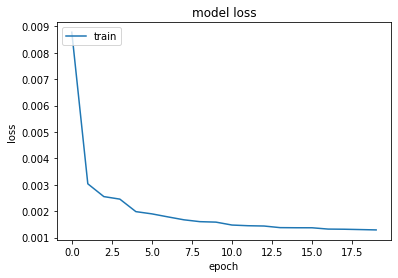

In [74]:
 plt.plot(error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Image Clustering

In [75]:
decoded_imgs = reconstructed_model.predict(X_test)

In [76]:
encoder2 = tf.keras.models.Model([reconstructed_model.layers[0].input],[reconstructed_model.layers[20].output])
decoded = encoder2.predict(X_test)  

In [77]:
decoded.shape

(10000, 4, 4, 256)

In [78]:
encoded_images = decoded.reshape(10000,4*4*256)

In [79]:
encoded_images.shape

(10000, 4096)

In [106]:
#an attempt to reduce the dimensions so that k-means clustering can work better
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(encoded_images)

In [107]:
#K-means
km=KMeans(n_clusters=10,init='k-means++',max_iter=1000)
clustered_images = km.fit_predict(principalComponents)

In [108]:
for cluster in range(10):
    print('cluster: ', cluster)
    a = np.array(Y_test[np.where(clustered_images == cluster)])
    print(np.bincount(a[:,0]))
    print("Probable cluster label : ",np.argmax(np.bincount(a[:,0])))

cluster:  0
[786 810 912 855 969 854 930 867 830 734]
Probable cluster label :  4
cluster:  1
[13 16  5 15  2 11 15  7  3 14]
Probable cluster label :  1
cluster:  2
[17 10  8  4  0  3  6  3  4  5]
Probable cluster label :  0
cluster:  3
[27 22  9  9  1 16  5 20 27 36]
Probable cluster label :  9
cluster:  4
[30 49 11  9  7 20  6 31 47 84]
Probable cluster label :  9
cluster:  5
[13 16  4  2  1  3  4  2 16 11]
Probable cluster label :  1
cluster:  6
[19 20 11 31  6 30 16  8  9 15]
Probable cluster label :  3
cluster:  7
[15  0  4  1  0  1  0  0  2  1]
Probable cluster label :  0
cluster:  8
[20 11  3  7  2  4  5  6  4  5]
Probable cluster label :  0
cluster:  9
[60 46 33 67 12 58 13 56 58 95]
Probable cluster label :  9


Class  0


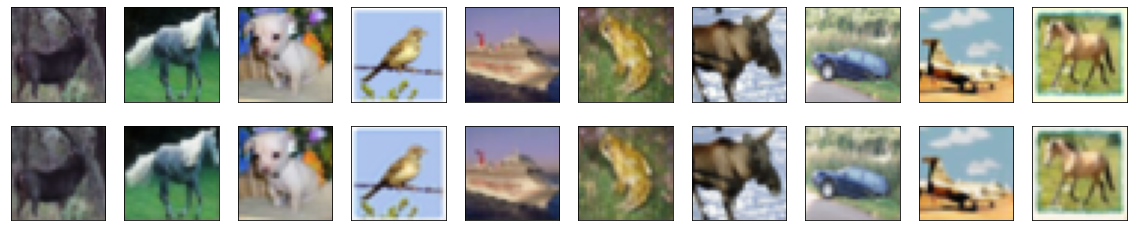

Class  1


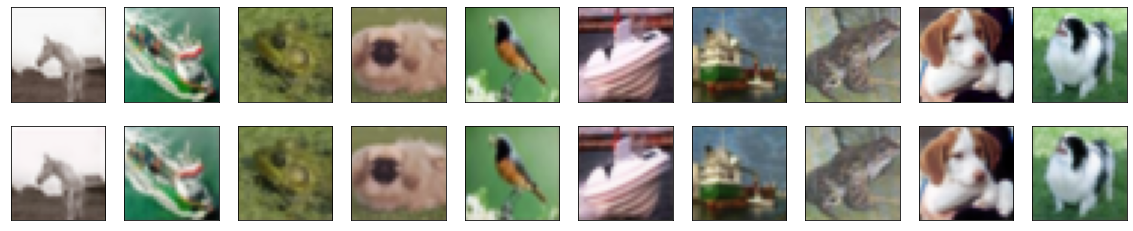

Class  2


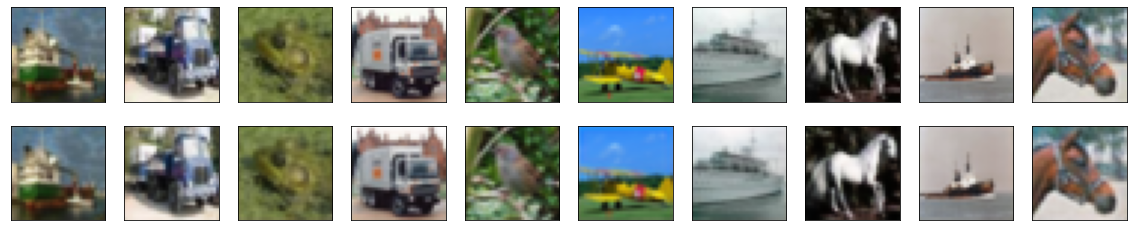

Class  3


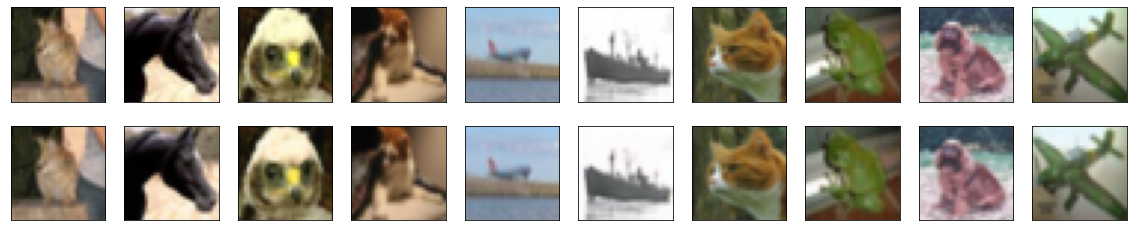

Class  4


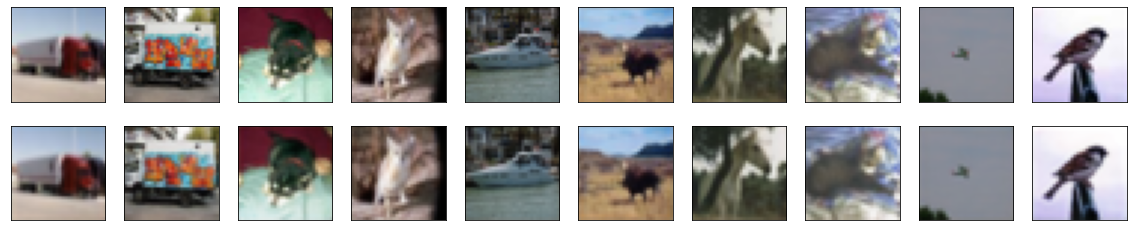

Class  5


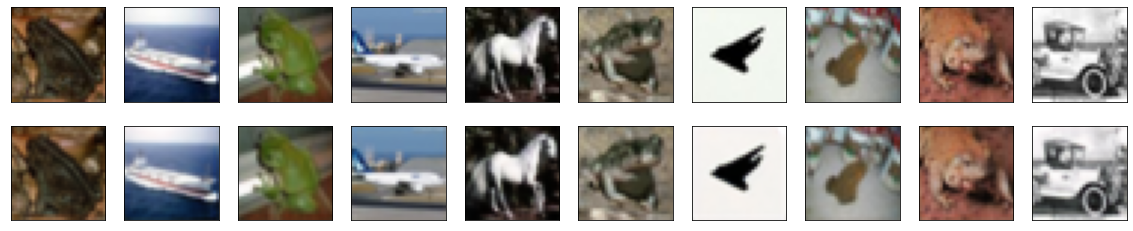

Class  6


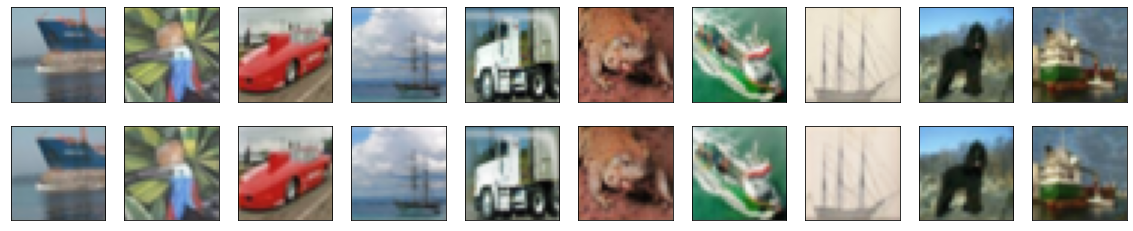

Class  7


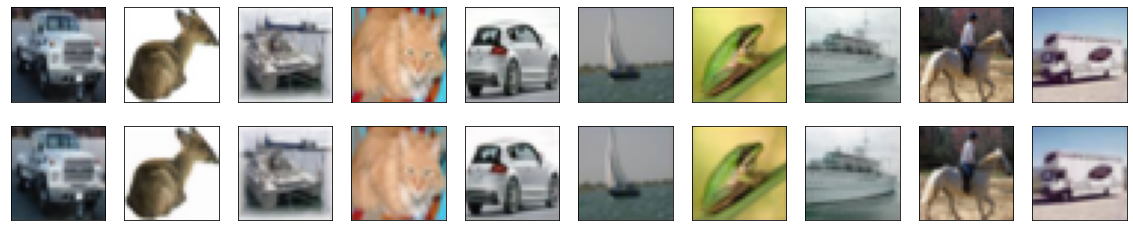

Class  8


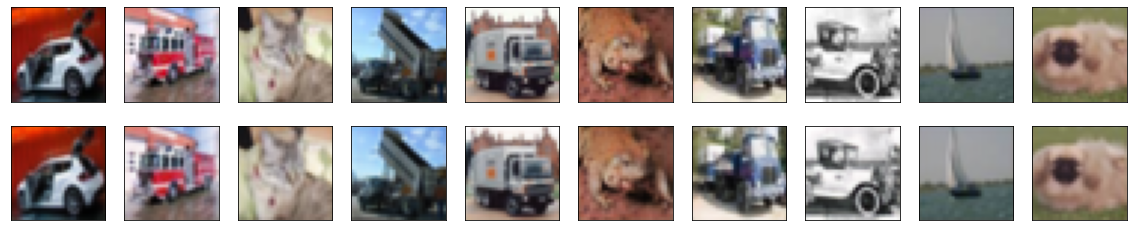

Class  9


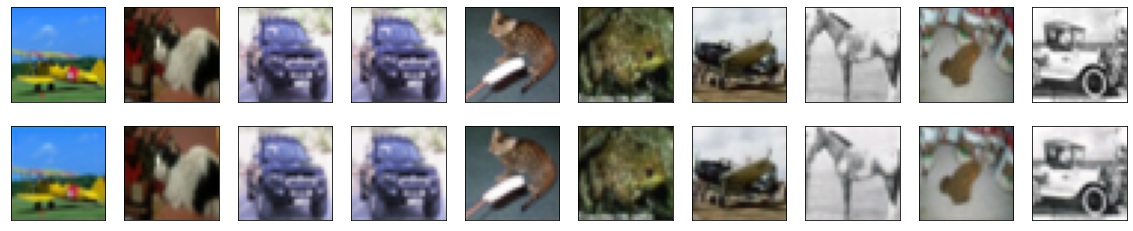

In [102]:
for i in range(10):
    n = 10
    count = 0 
    print("Class ",i)
    indices = np.array(np.where(copy==i))
    plt.figure(figsize=(20, 4))
    for j in range(n):
          # display original
        pos = random.randint(0,np.size(indices))
        ax = plt.subplot(2, n,j + 1)
        plt.imshow(X_test[pos].reshape(32,32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

          # display reconstruction
        ax = plt.subplot(2, n, j + 1 + n)
        plt.imshow(decoded_imgs[pos].reshape(32,32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        count+=1  
    plt.show()

The results of K-means is not really satisfactory. The model tends to cluster most of the images into a single class(in this run class 0).There a few classes that have not been represented.Probably using a more robust algorithm for clustering might help.There is a major scope for improvement.